# Feature Prep

In [1]:
import pandas as pd
import time
import random
from ml_fxns import map_rank, check_makuuchi, calculate_age, calculate_active_years, calculate_h2h_wp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# --- Import Data --- #
rikishi_df = pd.read_pickle('data/all_rikishi.pkl')
h2h_df = pd.read_pickle('data/recent_full_h2h.pkl')


# --- Apply Requisite Conditions Used to Extract H2H Data --- #
# only sumos that satisfied these conditions were used to store head-to-head data into h2h_df DataFrame
logical = rikishi_df['shikona'].map(lambda x: x is not None) & \
          rikishi_df['sumo_stable'].map(lambda x: x is not None) & \
          rikishi_df['bday'].map(lambda x: pd.notnull(x)) & \
          rikishi_df['debut'].map(lambda x: pd.notnull(x))
filtered_df = rikishi_df[logical]


# ----- Remove Rows Without Requisite Features ----- #
# eliminate missing data
logical = (pd.notnull(filtered_df['height'])) & (pd.notnull(filtered_df['weight'])) & \
        (pd.notnull(filtered_df['bday'])) & (pd.notnull(filtered_df['debut'])) & \
        (~filtered_df['highest_rank'].isnull()) & (filtered_df['highest_rank'].apply(check_makuuchi))

filtered_df = filtered_df[logical]

In [2]:
len(h2h_df)

192803

## Interpret Info on the Filtered Remaining Rikishi

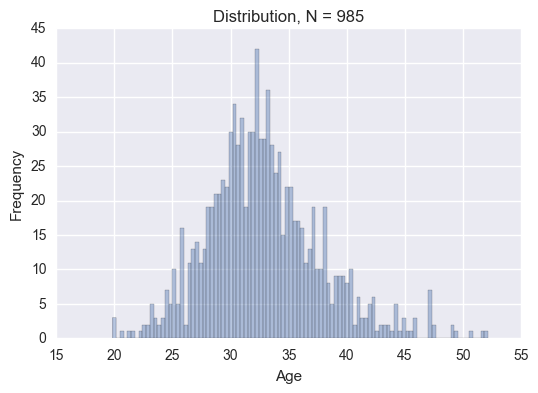

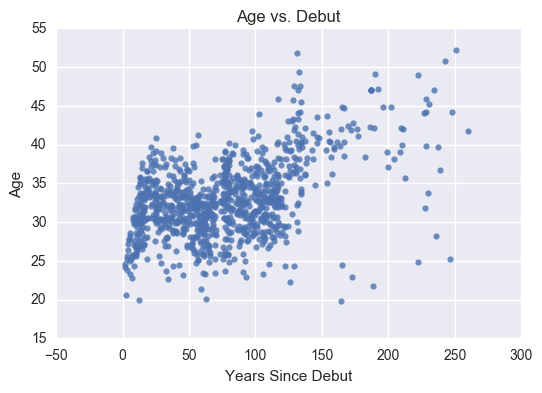

In [2]:
from datetime import datetime, timedelta
height = filtered_df['height']
weight = filtered_df['weight']
age = filtered_df['age']
active_years = filtered_df['active_years']
debut_diff = datetime.now() - filtered_df['debut']
debut_time = debut_diff.apply(lambda x: x.total_seconds()/31536000.)

fig1 = plt.figure()
plt.title('Distribution, N = ' + str(len(filtered_df)))
ax = sns.distplot(age, kde=False, bins=100)
ax.set(xlabel="Age", ylabel="Frequency");
# fig1.savefig('plots/age_distrib.png', dpi=300)

data_set = pd.DataFrame({'debut_time': debut_time, 'age': age, 'height': height, \
                         'weight': weight, 'active_years': active_years})

sns.set_style("darkgrid")
fig2 = plt.figure()
plt.title('Age vs. Debut')
ax = sns.regplot(x="debut_time", y="age", data=data_set, fit_reg=False)
ax.set(xlabel="Years Since Debut", ylabel="Age");
# fig2.savefig('plots/age_vs_debut.png', dpi=300)

# CONFIRMS THAT EARLIER SUMO WRESTLING PROFILES TEND TO BE OLDER
# BECAUSE MY ALGORITHM BEGINS SUBTRACTING AGE DIFFERENCES WITH SUMOS WHO CAME FIRST
# IN THE DATABASE ORDERED BY BIRTHDATE, I AM BIASING DATA TO HAVE POSITIVE AGE DIFF
# What I should really be doing is generating age differences based on a randomized order of 
# all_rikishi.pkl

# Also interesting to show that data becomes predominantly available starting 
# 50-60 years ago

# how to randomize h2h_df?
# random number generator to pick sumo1 or sumo2 as ID1
# generate feature based on this order, this way not skewed

In [3]:
h2h_df.head()

,date,tourney_day,ID1,shikona1,rank1,outcome1,kimarite,ID2,shikona2,rank2,outcome2,flag
0,2011-11-01,4.0,10722.0,Asanotosa Sho,Sandanme 23,kuro,tsukiotoshi,11888.0,Akinokawa,Sandanme 25,shiro,False
1,2002-03-01,1.0,10722.0,Asanotosa Sho,Sandanme 5,shiro,uwatenage,9967.0,Akinomine,Sandanme 6,kuro,False
2,2004-11-01,5.0,10722.0,Asanotosa Sho,Makushita 39,shiro,uwatenage,9967.0,Akinomine,Makushita 41,kuro,False
3,2006-09-01,11.0,10722.0,Asanotosa Sho,Sandanme 3,shiro,kotenage,9967.0,Akinomine,Sandanme 9,kuro,False
4,2007-03-01,6.0,10722.0,Asanotosa Sho,Sandanme 12,shiro,yorikiri,9967.0,Akinomine,Sandanme 14,kuro,False


# Machine Learning

In [4]:
## NOTE: RANDOMIZING ORDER OF H2H RECORDS REDUCED BIAS IN FEATURES BY ORDER OF MAGNITUDE

from sklearn import datasets, neighbors, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# feature_df = pd.read_pickle('data/randomized_feature_df.pkl')
feature_df = pd.read_pickle('data/recent_feature_df.pkl')

# recent_feature_df without rank info: 217531
# recent_feature_df with rank info   : 30262

### Plots to Make Sure Data Looks Reasonable

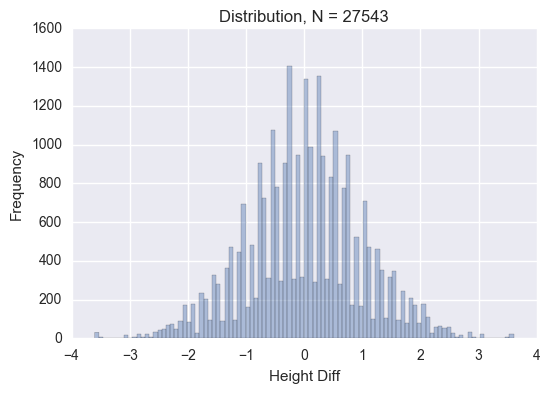

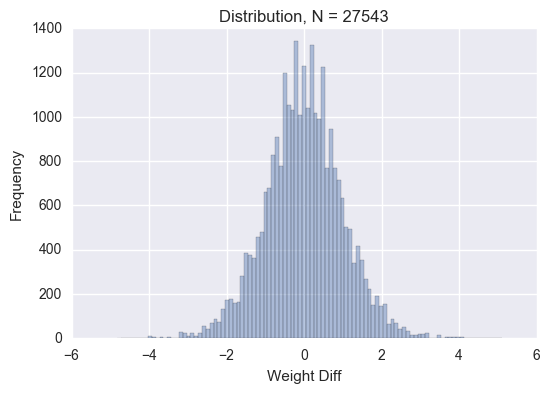

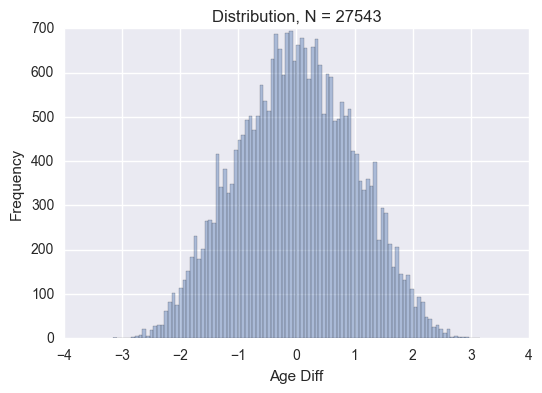

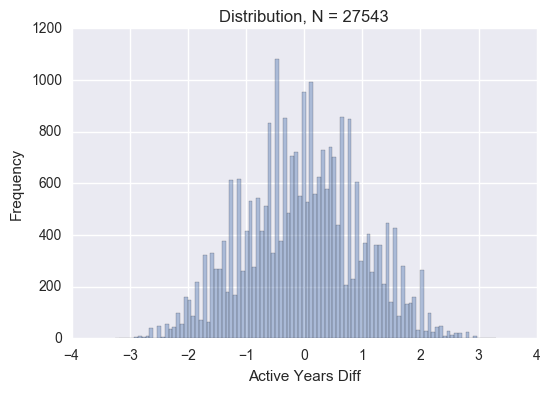

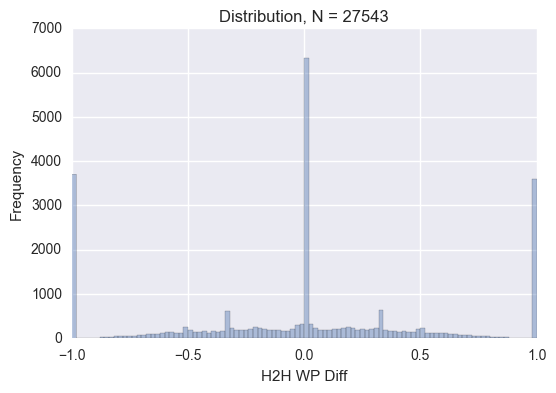

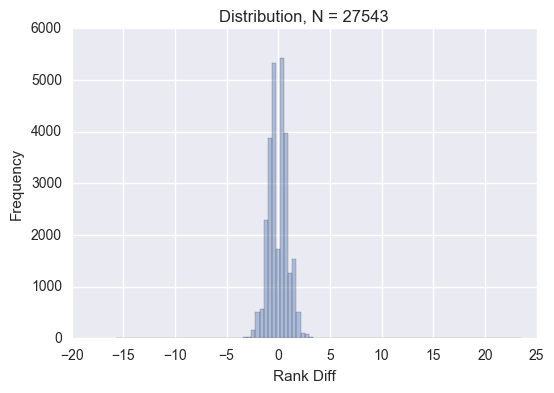

In [5]:
# explore histograms
X = feature_df.loc[:, ['height_diff', 'weight_diff', 'age_diff', 'active_diff', 'rank_diff', 'h2h_diff']]
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
X_scaled = scaler.fit_transform(X)

height_diff = X_scaled[:, 0]
weight_diff = X_scaled[:, 1]
age_diff= X_scaled[:, 2]
active_diff = X_scaled[:, 3]
rank_diff = X_scaled[:, 4]
h2h_diff = feature_df['h2h_diff']
# height_diff = feature_df['height_diff']
# weight_diff = feature_df['weight_diff']
# age_diff = feature_df['age_diff']
# active_diff = feature_df['active_diff']
# rank_diff = feature_df['rank_diff']

fig1 = plt.figure()
plt.title('Distribution, N = ' + str(len(feature_df)))
ax = sns.distplot(height_diff, kde=False, bins=100)
ax.set(xlabel="Height Diff", ylabel="Frequency");
# fig1.savefig('plots/height_diff_distrib.png', dpi=300)

fig2 = plt.figure()
plt.title('Distribution, N = ' + str(len(feature_df)))
ax = sns.distplot(weight_diff, kde=False, bins=100)
ax.set(xlabel="Weight Diff", ylabel="Frequency");
# fig2.savefig('plots/weight_diff_distrib.png', dpi=300)

fig3 = plt.figure()
plt.title('Distribution, N = ' + str(len(feature_df)))
ax = sns.distplot(age_diff, kde=False, bins=100)
ax.set(xlabel="Age Diff", ylabel="Frequency");
# fig3.savefig('plots/age_diff_distrib.png', dpi=300)

fig4 = plt.figure()
plt.title('Distribution, N = ' + str(len(feature_df)))
ax = sns.distplot(active_diff, kde=False, bins=100)
ax.set(xlabel="Active Years Diff", ylabel="Frequency");
# fig4.savefig('plots/active_years_diff_distrib.png', dpi=300)

fig5 = plt.figure()
plt.title('Distribution, N = ' + str(len(feature_df)))
ax = sns.distplot(h2h_diff, kde=False, bins=100)
ax.set(xlabel="H2H WP Diff", ylabel="Frequency");
# fig5.savefig('plots/h2h_diff_distrib.png', dpi=300)

fig6 = plt.figure()
plt.title('Distribution, N = ' + str(len(feature_df)))
ax = sns.distplot(rank_diff, kde=False, bins=100)
ax.set(xlabel="Rank Diff", ylabel="Frequency");
# fig6.savefig('plots/rank_diff_distrib.png', dpi=300)

## Evaluate Algorithm Performance

In [8]:
X = feature_df.loc[:, ['height_diff', 'weight_diff', 'age_diff', 'active_diff', 'rank_diff', 'h2h_diff']]
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
X_scaled = scaler.fit_transform(X)
X_scaled[:, 5] = feature_df['h2h_diff']  # make sure h2h_diff NOT standardized

y = feature_df.loc[:, 'label']  # labels, outcomes for first sumo (1 for wins, 0 for losses)


# --- Initialize Model --- #
# NO bias unit, b/c if all values are the same, we should expect 50% probability when features are ZERO in value
logistic = linear_model.LogisticRegression(fit_intercept=False)


# ========== MODEL EVALUATION (Comment Out For New Predictions) ========== #
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

# N ~ 985 viable makuuchi-division sumo wrestlers
# Using ht, wt, age, active, h2h, rank differences: 0.57 cross-validation accuracy (newest method)

LogisticRegression score: 0.572497


In [9]:
probs = logistic.predict_proba(X_test)
pred_and_prob = zip(y_test, probs)  # displays prediction probabilities

# of the predictions, how many are over 90% certain?

def count_certainty(probs):
    count = 0
    for row in probs:
        if (row[0] > 0.90) or (row[1] > 0.90):
            count += 1
            
    return count

count_certainty(probs)

# of 9987 test samples, 1169 were over 90% certain to be correct --> 11.7%
# With 11.7% certainty rate, can only bet on 35 of 300 matches in a tournament

5

In [17]:
# how do I interpret the prediction probabilities?
# prob1 = chance that prediction belongs in loser class
# prob2 = chance that prediction belongs in winner class

array([0, 1])

## Calibration Curves

In [11]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

# Create classifiers
lr = LogisticRegression()

/Users/vincentchow/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


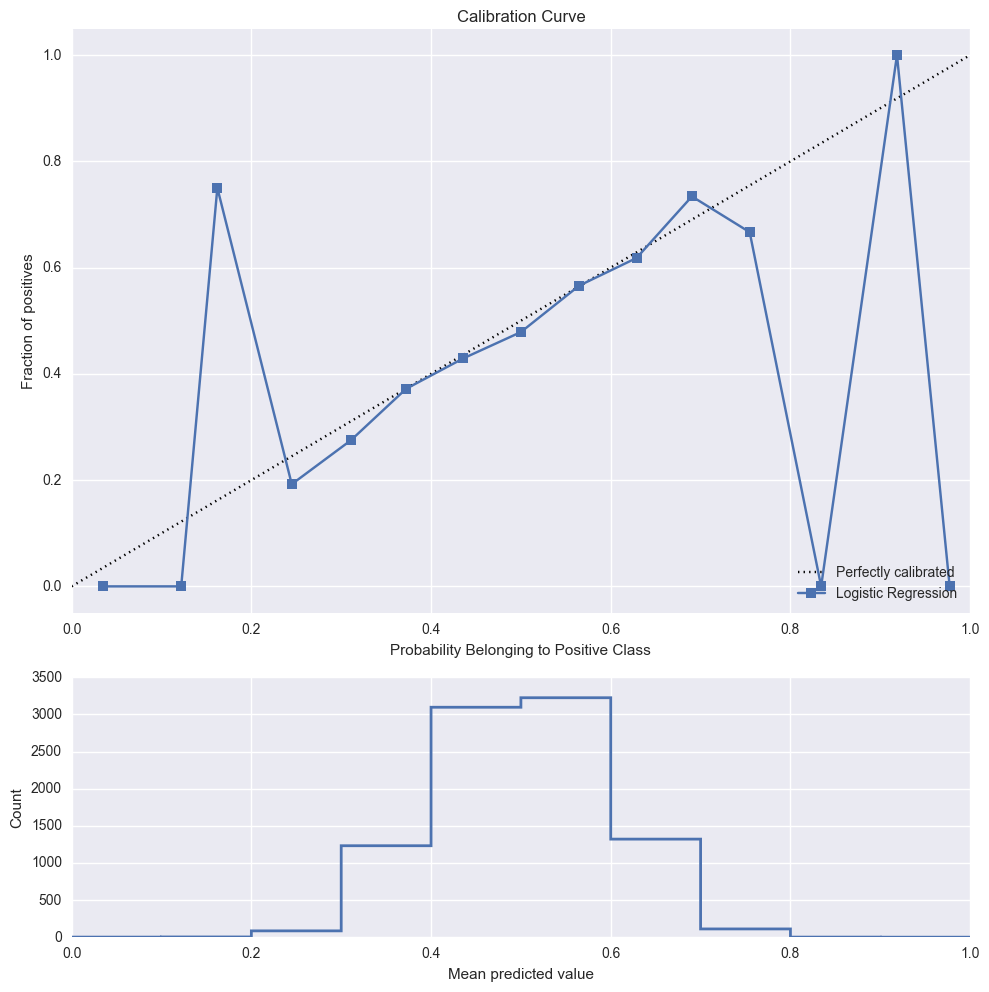

In [12]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

lr.fit(X_train, y_train)
prob_pos = lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=15)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label='Logistic Regression')

ax2.hist(prob_pos, range=(0, 1), bins=10, histtype="step", lw=2)

ax1.set_xlabel("Probability Belonging to Positive Class")
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration Curve')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Learning Curves

### LEARNING CURVE: ERROR VS. TRAINING SAMPLES

In [13]:
estimator = linear_model.LogisticRegression(fit_intercept=False)

N = 10
n_samples = X_train.shape[0]
train_error, test_error = [], []
for n in range(10, n_samples/2, N):
    estimator.fit(X_train[0:(n-1)], y_train[0:(n-1)])
    train_error.append(1.0 - estimator.score(X_train[0:n-1], y_train[0:n-1]))
    test_error.append(1.0 - estimator.score(X_test, y_test))
    
print "Done"

Done


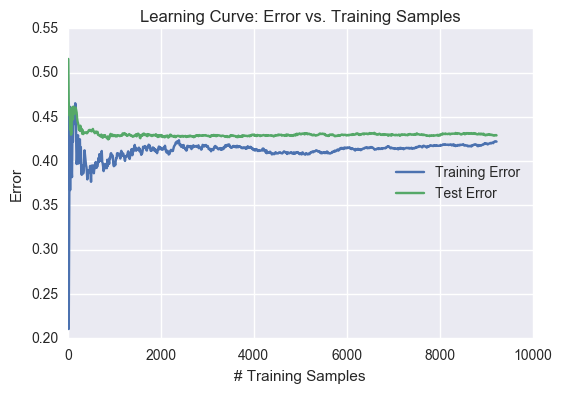

In [14]:
fig1 = plt.figure()
plt.plot(range(10, n_samples/2, N), train_error, label='Training Error')
plt.plot(range(10, n_samples/2, N), test_error, label='Test Error')
plt.xlim([0, 10000])
plt.legend(loc='center right', shadow=True)
plt.title('Learning Curve: Error vs. Training Samples')
plt.xlabel('# Training Samples')
plt.ylabel('Error')
# fig1.savefig('plots/lr_learning_curve.png', dpi=300)

# Info Learned:
# - collecting more data will not help (curves converge)
# - it takes less than 1000 data points for curves to to converge (can prob train on the most recent sumos)

### LEARNING CURVE: ERROR VS. REGULARIZATION

In [15]:
import numpy as np

start = 0
stop = 5
N = 100
n_samples = X_train.shape[0]
train_error, test_error = [], []
for n in np.logspace(start, stop, N, base=10.0, dtype='int64'):
    estimator = linear_model.LogisticRegression(fit_intercept=False, C=n)
    estimator.fit(X_train, y_train)
    train_error.append(1.0 - estimator.score(X_train, y_train))
    test_error.append(1.0 - estimator.score(X_test, y_test))
    
print "Done"

Done


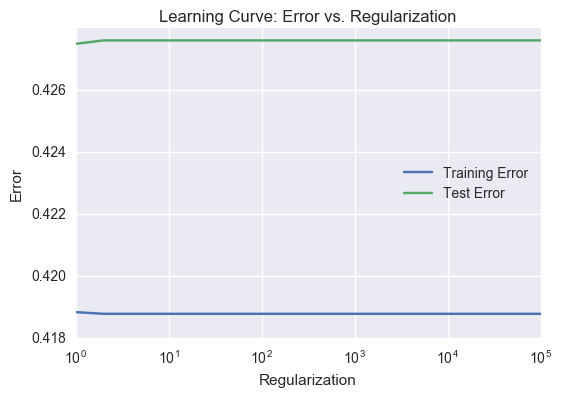

In [16]:
fig1 = plt.figure()
plt.plot(np.logspace(start, stop, N, dtype='int64'), train_error, label='Training Error')
plt.plot(np.logspace(start, stop, N, dtype='int64'), test_error, label='Test Error')
# plt.xlim([0, 50000])
plt.legend(loc='center right', shadow=True)
plt.title('Learning Curve: Error vs. Regularization')
plt.xlabel('Regularization')
plt.ylabel('Error')
plt.xscale('log')
# fig1.savefig('plots/lr_learning_curve_regularization.png', dpi=300)
